In [265]:
import pandas as pd
import string
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from shapely.geometry import Point
import geopandas 
from geopandas import GeoDataFrame
import ast

In [266]:
coffee_buz =  pd.read_csv('coffee_businesses.csv')

In [267]:
coffee_buz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2061 entries, 0 to 2060
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   2061 non-null   object 
 1   name          2061 non-null   object 
 2   address       2054 non-null   object 
 3   city          2061 non-null   object 
 4   state         2061 non-null   object 
 5   postal_code   2061 non-null   object 
 6   latitude      2061 non-null   float64
 7   longitude     2061 non-null   float64
 8   stars         2061 non-null   float64
 9   review_count  2061 non-null   int64  
 10  is_open       2061 non-null   int64  
 11  attributes    2044 non-null   object 
 12  categories    2061 non-null   object 
 13  hours         1794 non-null   object 
dtypes: float64(3), int64(2), object(9)
memory usage: 225.5+ KB


In [268]:
coffee_buz.sample()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
688,JIMGLsZofs94iwa0xx2ncQ,Starbucks,723 Broadway,Saugus,MA,01906,42.47831,-71.023195,2.5,39,0,"{'RestaurantsPriceRange2': '2', 'BusinessParki...","Coffee & Tea, Restaurants, Food","{'Monday': '4:30-21:30', 'Tuesday': '4:30-21:3..."


In [269]:
def split(s):
    return s.split(", ")

#extracting categories
def categories_type(l):
    d = {}
    l=l.dropna().copy()
    l['categories'] = l['categories'].apply(split)
    for row in l.index:
        stars = l.loc[row, ]['stars']
        for c in l.loc[row, ]['categories']:
            
            if c not in d.keys():
                d[c] = [stars]
            else:
                d[c].append(stars)
    
    rest_categories = pd.DataFrame({'stars':list(d.values())})
    rest_categories.index = d.keys()
    rest_categories['number'] = rest_categories['stars'].apply(lambda a : len(a))
    rest_categories['percentage'] = rest_categories['number'] / len(l) * 100
    rest_categories['average_stars'] = rest_categories['stars'].apply(lambda a : sum(a) / len(a))
    rest_categories = rest_categories.drop(['stars'], axis=1)
    
    return rest_categories

#extracting attributes
def get_rests_from_attributes(df,args):
    df=df.dropna().copy()
    partof_rests = pd.DataFrame({'name':df['name'], 'stars':df['stars']})
    def helper(attribute):
        attributes = []
        for a in df['attributes']:
            a=ast.literal_eval(a)
            if attribute in a.keys():
                attributes.append(a[attribute])
            else:
                attributes.append(None)
            
        return attributes

    for i in range(len(args)):
        attribute = args[i]
        partof_rests[attribute] = helper(attribute)
    
    return partof_rests

In [270]:
coffee_cat =categories_type(coffee_buz)
top10 = coffee_cat.sort_values('number', ascending = False)[2:]
top10[0:10]

,number,percentage,average_stars
Restaurants,688,38.695163,3.570494
Bakeries,196,11.023622,3.869898
Donuts,192,10.798650,2.736979
Cafes,186,10.461192,3.978495
Breakfast & Brunch,181,10.179978,3.787293
Sandwiches,176,9.898763,3.781250
Desserts,139,7.817773,4.039568
Coffee Roasteries,113,6.355456,4.199115
Juice Bars & Smoothies,108,6.074241,3.916667
Fast Food,89,5.005624,2.185393


In [271]:
coffee_cat[coffee_cat['number'] >=40].sort_values('average_stars', ascending = False)[:5]
#plt.scatter(coffee_cat.number,coffee_cat.average_stars)
#plt.xlim([0,100])

,number,percentage,average_stars
Coffee Roasteries,113,6.355456,4.199115
Specialty Food,40,2.249719,4.112500
Desserts,139,7.817773,4.039568
Ice Cream & Frozen Yogurt,71,3.993251,4.000000
Cafes,186,10.461192,3.978495


In [272]:
coffee_buz.attributes[19]

'{\'RestaurantsTakeOut\': \'False\', \'RestaurantsDelivery\': \'False\', \'GoodForKids\': \'True\', \'WiFi\': "u\'free\'", \'BusinessParking\': "{\'garage\': None, \'street\': True, \'validated\': None, \'lot\': None, \'valet\': False}"}'

In [293]:
coffee_attr = get_rests_from_attributes(coffee_buz,['WiFi','NoiseLevel',
                                                    'BikeParking','OutdoorSeating',
                                                    'RestaurantsPriceRange2',
                                                    'RestaurantsTakeOut',
                                                   'BusinessAcceptsBitcoin','HasTV','BusinessAcceptsCreditCards'])
coffee_attr.sample(2)

,name,stars,WiFi,NoiseLevel,BikeParking,OutdoorSeating,RestaurantsPriceRange2,RestaurantsTakeOut,BusinessAcceptsBitcoin,HasTV,BusinessAcceptsCreditCards
1504,Dunkin',1.5,u'free',None,None,None,1,True,None,None,True
965,Starbucks,3.5,u'free',None,True,True,1,True,None,None,True


In [294]:
import re
import seaborn as sns
def replace_u(s):
    return re.sub('u'+r"'",r"'",str(s))

coffee_attr['WiFi']=coffee_attr['WiFi'].apply(replace_u)
coffee_attr['NoiseLevel']=coffee_attr['NoiseLevel'].apply(replace_u)


coffee_attr.sample()


,name,stars,WiFi,NoiseLevel,BikeParking,OutdoorSeating,RestaurantsPriceRange2,RestaurantsTakeOut,BusinessAcceptsBitcoin,HasTV,BusinessAcceptsCreditCards
964,Gold Cup Coffee,4.5,'free',None,None,None,None,None,None,None,True


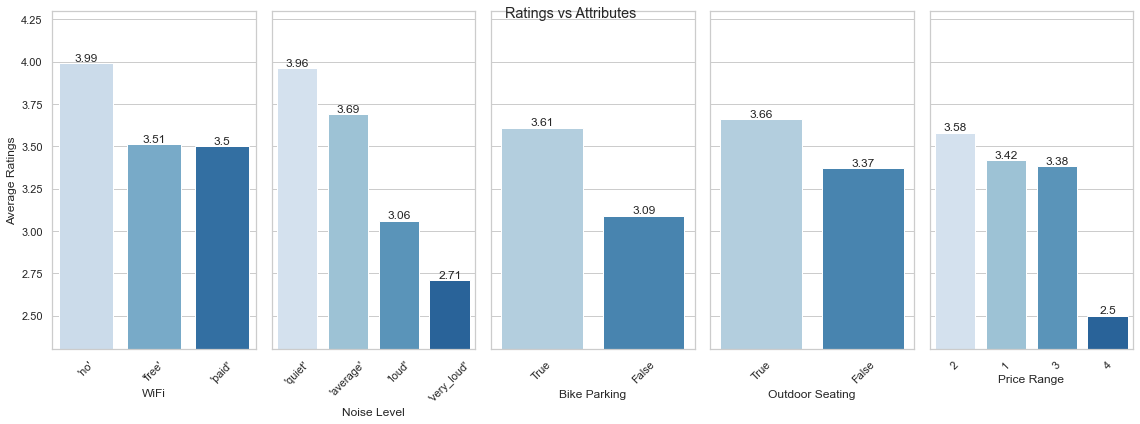

In [295]:
attributes = ['WiFi','NoiseLevel','BikeParking','OutdoorSeating',
             'RestaurantsPriceRange2']
attributes_name=['WiFi','Noise Level','Bike Parking','Outdoor Seating',
             'Price Range']
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=1,ncols=len(attributes), sharey=True, figsize=(16,6))
i=0
for attr in attributes:
    df = round(coffee_attr.groupby([attr]).mean().reset_index(),2)
    df = df[df[attr]!="None"].sort_values('stars', ascending = False)
    plt.sca(axes[i])
    axes[i]=sns.barplot(x = attr, y = 'stars', data = df, palette = 'Blues')
    axes[i].set(xlabel=attributes_name[i])
    axes[i].set(ylabel='')
    if i==0:
        axes[i].set(ylabel='Average Ratings')
    axes[i].bar_label(axes[i].containers[0])
    axes[i].tick_params(axis='x', rotation=45)

    i+=1
    #plt.ylabel('Average Rating',fontsize=10)
plt.ylim([2.3, 4.3])
fig.tight_layout()
fig.suptitle('Ratings vs Attributes')
plt.show()


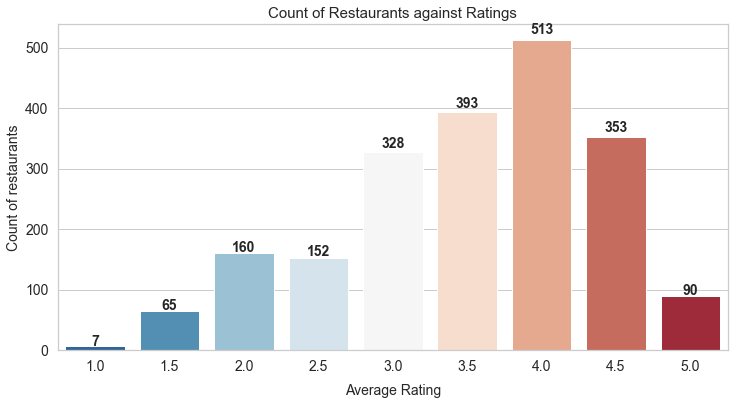

In [276]:
plt.figure(figsize=(12,6))
grouped = coffee_buz.stars.value_counts().sort_index()
sns.barplot(x=grouped.index, y=grouped.values, palette=sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Average Rating', labelpad=10, fontsize=14)
plt.ylabel('Count of restaurants', fontsize=14)
plt.title('Count of Restaurants against Ratings', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

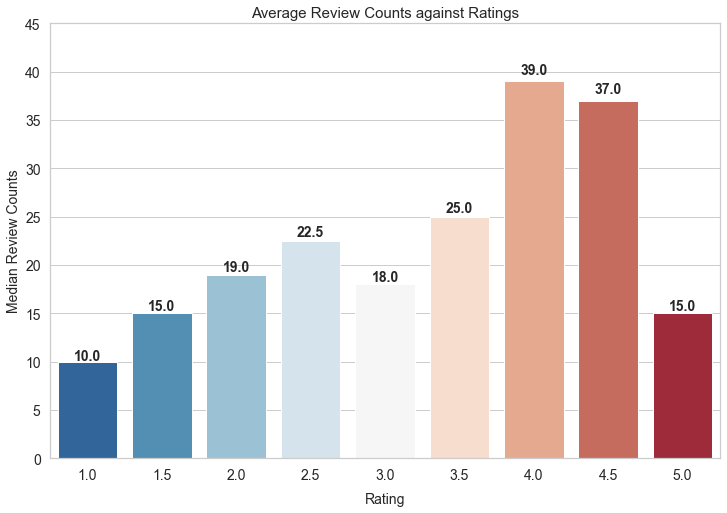

In [277]:
plt.figure(figsize=(12,8))
grouped = coffee_buz.groupby(['stars']).median().reset_index()
sns.barplot(x=grouped.stars, y=grouped.review_count, palette=sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Rating', labelpad=10, fontsize=14)
plt.ylabel('Median Review Counts', fontsize=14)
plt.title('Average Review Counts against Ratings', fontsize=15)
plt.tick_params(labelsize=14)
plt.ylim([0,45])
for i in grouped.index:
    v=round(grouped['review_count'][i],2)
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

In [296]:
from datetime import datetime
import math
FMT = '%H:%M'
def time_diff(h):
    h=str(h)
    if h!='nan':
        h=ast.literal_eval(h)
        ttl=0
        for i in h :
            s=h[i].split('-')
            #print(s)
            op=datetime.strptime(s[0], FMT)
            #print(op)
            #print(s[1])
            #print(op.hour)
            cl=datetime.strptime(s[1], FMT)
            diff=(cl.hour-op.hour)
            if diff>=0:
                ttl+=diff
            else:
                ttl+=24+diff
            #ttl=op.hour

        return ttl/7
    else:
        return -999
coffee_buz['total_hours']=  coffee_buz['stars']*0
#print(coffee.total)
coffee_buz['total_hours']=coffee_buz['hours'].apply(time_diff)

10.857142857142858


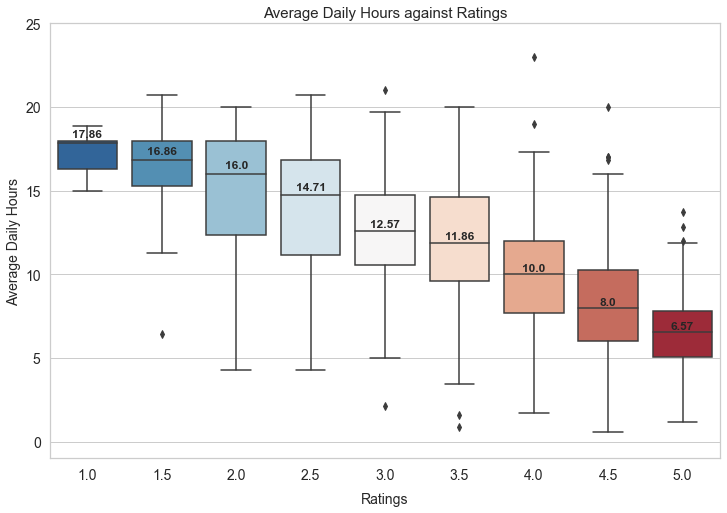

In [418]:
df = coffee_buz.copy()
df=df[df.total_hours!=-999]
df=df[df.total_hours!=0]
plt.figure(figsize=(12,8))
grouped = df.groupby(['stars']).median().reset_index()
sns.boxplot(x=df.stars, y=df.total_hours, palette=sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Ratings', labelpad=10, fontsize=14)
plt.ylabel('Average Daily Hours', fontsize=14)
plt.title('Average Daily Hours against Ratings', fontsize=15)
plt.tick_params(labelsize=14)
plt.ylim([-1,25])
for i in grouped.index:
    v=round(grouped['total_hours'][i],2)
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=12)
print(df.total_hours.median())

In [298]:
def rating(star):
    if star<4:
        return 0
    else: return 1
coffee_attr['rating']=coffee_attr['stars'].apply(rating)

In [605]:
temp = pd.get_dummies(coffee_attr,columns=['WiFi','NoiseLevel','BikeParking','OutdoorSeating',
                                    'RestaurantsPriceRange2','BusinessAcceptsBitcoin','HasTV','BusinessAcceptsCreditCards',
                                          'RestaurantsTakeOut'],drop_first=True)
temp.sample()

,name,stars,rating,WiFi_'no',WiFi_'paid',WiFi_None,NoiseLevel_'loud',NoiseLevel_'quiet',NoiseLevel_'very_loud',NoiseLevel_None,...,OutdoorSeating_True,RestaurantsPriceRange2_2,RestaurantsPriceRange2_3,RestaurantsPriceRange2_4,RestaurantsPriceRange2_None,BusinessAcceptsBitcoin_True,HasTV_True,BusinessAcceptsCreditCards_True,RestaurantsTakeOut_None,RestaurantsTakeOut_True
1332,Starbucks,3.5,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,0,1,0,1


In [606]:
def map1(x):
    if x==-999:
        return 10.5
    else: return x
temp['total_hours']=coffee_buz['total_hours']
temp['review_count']=coffee_buz['review_count']
print(temp.columns)
temp=temp.drop(columns=['WiFi_None','NoiseLevel_None','BikeParking_None',
                   'OutdoorSeating_None',
                   'RestaurantsPriceRange2_None','RestaurantsTakeOut_None'])
features = temp.columns[3:]
features

Index(['name', 'stars', 'rating', 'WiFi_'no'', 'WiFi_'paid'', 'WiFi_None',
       'NoiseLevel_'loud'', 'NoiseLevel_'quiet'', 'NoiseLevel_'very_loud'',
       'NoiseLevel_None', 'BikeParking_None', 'BikeParking_True',
       'OutdoorSeating_None', 'OutdoorSeating_True',
       'RestaurantsPriceRange2_2', 'RestaurantsPriceRange2_3',
       'RestaurantsPriceRange2_4', 'RestaurantsPriceRange2_None',
       'BusinessAcceptsBitcoin_True', 'HasTV_True',
       'BusinessAcceptsCreditCards_True', 'RestaurantsTakeOut_None',
       'RestaurantsTakeOut_True', 'total_hours', 'review_count'],
      dtype='object')


Index(['WiFi_'no'', 'WiFi_'paid'', 'NoiseLevel_'loud'', 'NoiseLevel_'quiet'',
       'NoiseLevel_'very_loud'', 'BikeParking_True', 'OutdoorSeating_True',
       'RestaurantsPriceRange2_2', 'RestaurantsPriceRange2_3',
       'RestaurantsPriceRange2_4', 'BusinessAcceptsBitcoin_True', 'HasTV_True',
       'BusinessAcceptsCreditCards_True', 'RestaurantsTakeOut_True',
       'total_hours', 'review_count'],
      dtype='object')

In [607]:
from sklearn.preprocessing import StandardScaler
scl=StandardScaler()
X=temp[features]
X=scl.fit_transform(X)
y=temp.rating


In [608]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,silhouette_score
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis,LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
classifiers=[LogisticRegression(C=1e3,max_iter=100),DecisionTreeClassifier(max_depth=7),
             RandomForestClassifier(max_depth=8),
            AdaBoostClassifier(),SVC(),KNeighborsClassifier(5),BernoulliNB(),LinearDiscriminantAnalysis()]

In [609]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=10)
#X_train_train,X_valid,y_train_train,y_valid = train_test_split(X_train,y_train,stratify=y_train,test_size=0.1,random_state=1)

for clf in classifiers:
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(clf.__class__.__name__)
    print("Mean CV Accuracy {acc:.3f} with standard deviation {std:.3f}".format(acc=scores.mean(),std=scores.std()))
    print()

LogisticRegression
Mean CV Accuracy 0.658 with standard deviation 0.022

DecisionTreeClassifier
Mean CV Accuracy 0.705 with standard deviation 0.017

RandomForestClassifier
Mean CV Accuracy 0.745 with standard deviation 0.011

AdaBoostClassifier
Mean CV Accuracy 0.742 with standard deviation 0.014

SVC
Mean CV Accuracy 0.709 with standard deviation 0.031

KNeighborsClassifier
Mean CV Accuracy 0.673 with standard deviation 0.031

BernoulliNB
Mean CV Accuracy 0.682 with standard deviation 0.019

LinearDiscriminantAnalysis
Mean CV Accuracy 0.652 with standard deviation 0.021



In [635]:
clf =RandomForestClassifier(max_depth=8)
clf.fit(X_train,y_train)
print(clf.__class__.__name__)
print('Train Accuracy' ,clf.score(X_train,y_train))
print('Test Accuracy' ,clf.score(X_test,y_test))

RandomForestClassifier
Train Accuracy 0.8284106891701828
Test Accuracy 0.7612359550561798


In [636]:
print(classification_report(clf.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       181
           1       0.76      0.74      0.75       175

    accuracy                           0.76       356
   macro avg       0.76      0.76      0.76       356
weighted avg       0.76      0.76      0.76       356

